In [1]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from numpy.fft import rfft, irfft, fft, ifft

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
#observation = "data/obs/56207.39_GBT_1400"
#observation = "data/obs/56214.26_GBT_1400"
observation = "data/obs/56477.53_AO_1400"
#observation = "data/obs/56201.32_AO_1400"
#observation = "data/obs/56180.35_AO_1400"
template = "template-work/56412.76_GBT_1400.scrunch.sm"
#template = "template-work/56736.85_AO_1400.profile.psrsmooth"
#processing_name = "wideband"
processing_name = "singlefrequency"
obsname = observation.split("/")[-1]

In [3]:
F = psrchive.Archive_load(glob(join(observation,processing_name,"scrunch_*.ar"))[0])
F.tscrunch()
F.fscrunch()
F.dedisperse()
F.remove_baseline()
F.convert_state('Stokes')
nbin = F.get_nbin()

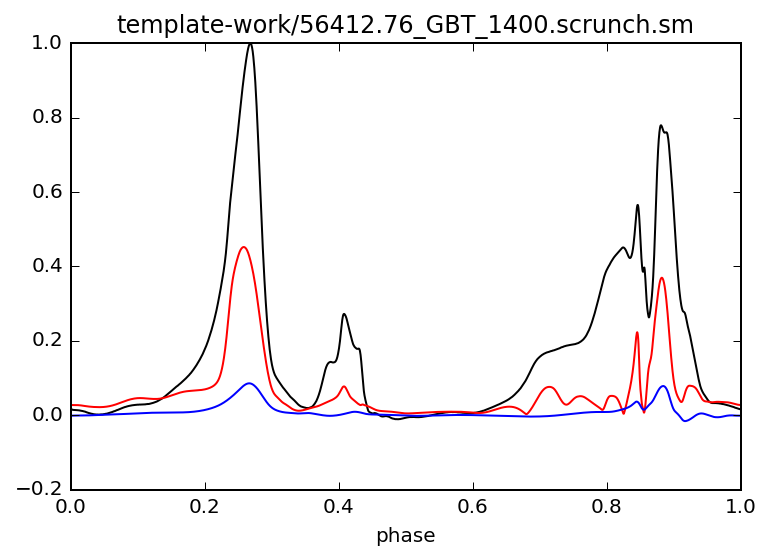

In [5]:
T = psrchive.Archive_load(template)
T.dedisperse()
T.convert_state('Stokes')
T.remove_baseline()
t_values = T.get_data()[0,:,0,:]
t_values = np.array([pipe.convert_template(t_values[i], F.get_nbin()) for i in range(4)])
# shift fundamental to zero phase
a = np.angle(np.fft.fft(t_values[0])[1])/(2*np.pi)
t_values = np.array([pipe.rotate_phase(p, -a) for p in t_values])
t_phases = np.linspace(0,1,t_values.shape[-1],endpoint=False)
t_values /= np.amax(t_values)
plt.plot(t_phases,t_values[0],color='k')
plt.plot(t_phases,np.hypot(t_values[1],t_values[2]),color='r')
plt.plot(t_phases,t_values[3],color='b')
plt.xlim(0,1)
plt.xlabel("phase")
plt.title(template)

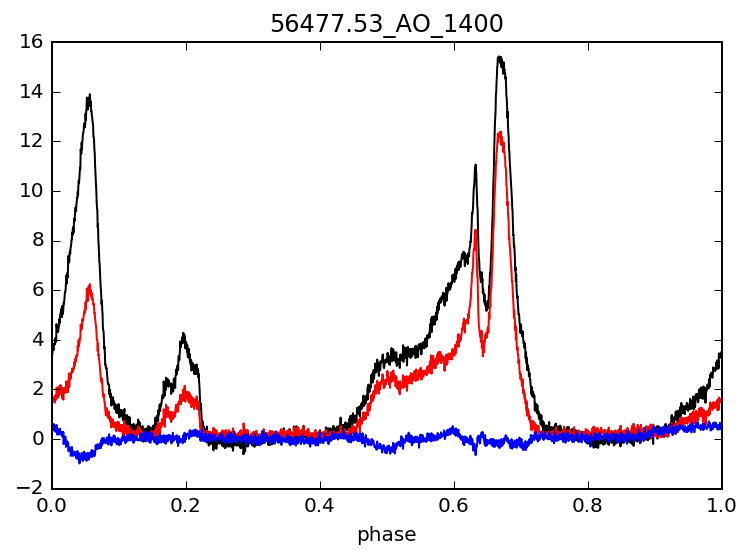

In [6]:

values = F.get_data()[0,:,0,:]
plt.plot(t_phases,values[0],color='k')
plt.plot(t_phases,np.hypot(values[1],values[2]),color='r')
plt.plot(t_phases,values[3],color='b')
plt.xlim(0,1)
plt.xlabel("phase")
plt.title(obsname)

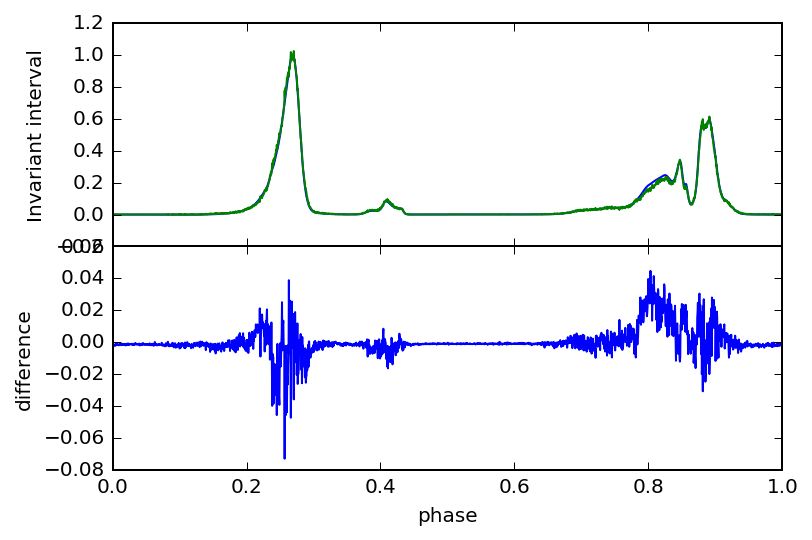

In [7]:
t_inv_int = t_values[0]**2-np.sum(t_values[1:]**2, axis=0)
t_inv_int /= np.amax(t_inv_int)
inv_int = values[0]**2-np.sum(values[1:]**2, axis=0)
phase, amp, bg = align_scale_profile(inv_int, t_inv_int)
inv_int = rotate_phase(inv_int, phase)*amp + bg

plt.subplot(211)
plt.plot(t_phases, t_inv_int)
plt.plot(t_phases, inv_int)
plt.tick_params(axis='x', labelbottom='off')
plt.ylabel("Invariant interval")
plt.subplot(212)
plt.plot(t_phases, t_inv_int-inv_int)
plt.xlabel("phase")
plt.ylabel("difference")
plt.subplots_adjust(hspace=0)
plt.savefig("invariant-interval.pdf")

In [8]:
def fit_mueller(goal, data):
    Acols = []
    names = []

    def pack_iquv(iquv):
        n, l = iquv.shape
        if n!=4:
            raise ValueError
        return np.reshape(iquv, l*n)
    def unpack_iquv(d):
        ln = len(d)
        if ln % 4:
            raise ValueError
        l = ln//4
        return np.reshape(d, (4,l))
    for i in range(4):
        for j in range(4):
            M = np.zeros((4,4))
            M[i,j] = 1
            d = np.dot(M,data)
            Acols.append(pack_iquv(d))
            names.append(("M",(i,j)))
    for i in range(4):
        d = np.zeros_like(data)
        d[i,:] = 1
        Acols.append(pack_iquv(d))
        names.append(("const",i))
    
    A = np.array(Acols).T
    x, rk, res, s = np.linalg.lstsq(A, pack_iquv(goal))
    d = np.dot(A, x)
    return unpack_iquv(d), x, names


In [9]:
markersize=1.5

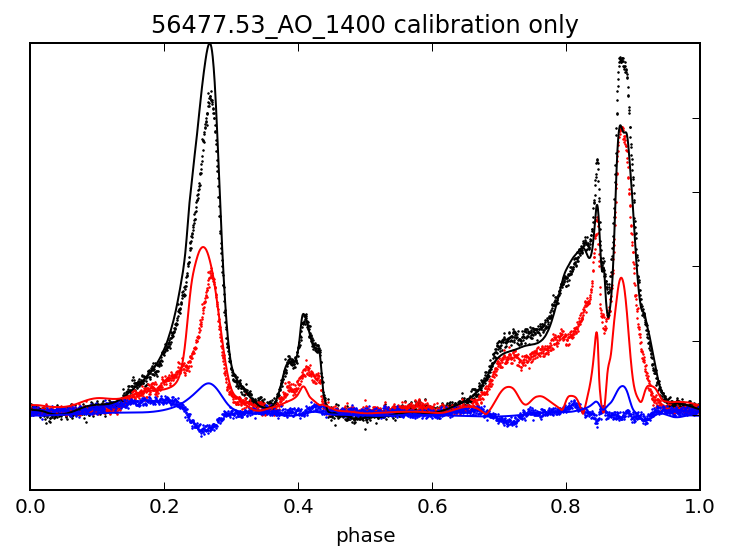

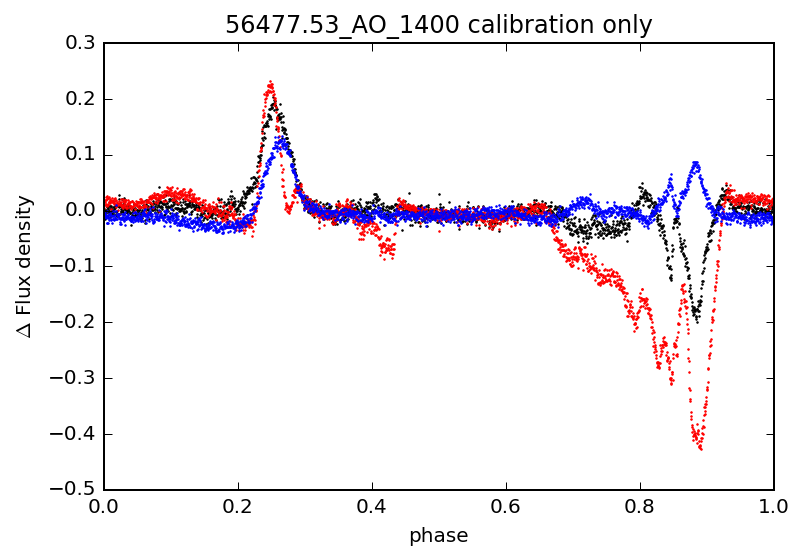

In [12]:
phase, amp, bg = align_scale_profile(values[0],t_values[0])
r_values = np.empty_like(values)
for i in range(4):
    r_values[i] = amp*rotate_phase(values[i], phase) + bg

plt.plot(t_phases,r_values[0],'.',markersize=markersize, color='k')
plt.plot(t_phases,np.hypot(r_values[1],r_values[2]),'.',markersize=markersize,color='r')
plt.plot(t_phases,r_values[3],'.',markersize=markersize,color='b')
plt.plot(t_phases,t_values[0],color='k')
plt.plot(t_phases,np.hypot(t_values[1],t_values[2]),color='r')
plt.plot(t_phases,t_values[3],color='b')

plt.xlim(0,1)
plt.xlabel("phase")
plt.gca().tick_params("y", left="off", labelleft="off")
plt.title(obsname+" calibration only")
plt.savefig("polarization-cal-"+obsname+".pdf")

plt.figure()
plt.plot(t_phases,(t_values-r_values)[0],'.',markersize=markersize,color='k')
plt.plot(t_phases,np.hypot(t_values[1],t_values[2])-np.hypot(r_values[1],r_values[2]),'.',markersize=markersize,color='r')
plt.plot(t_phases,(t_values-r_values)[3],'.',markersize=markersize,color='b')
plt.xlim(0,1)
plt.xlabel("phase")
plt.ylabel(r"$\Delta$ Flux density")
plt.title(obsname+" calibration only")


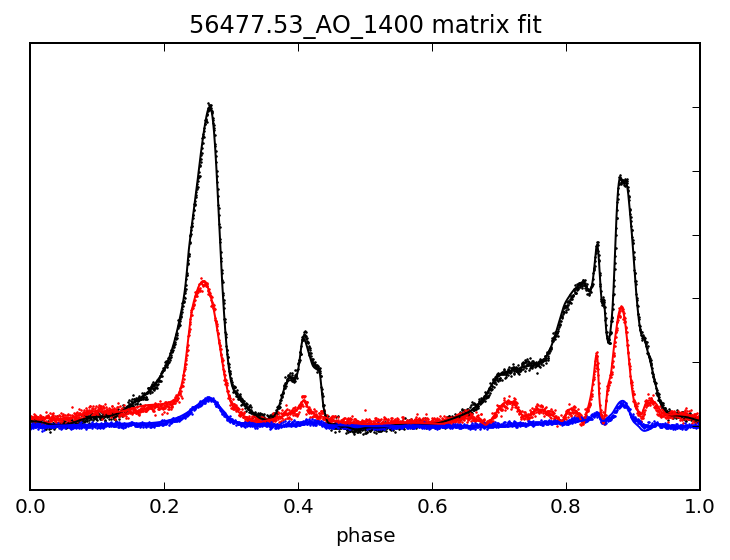

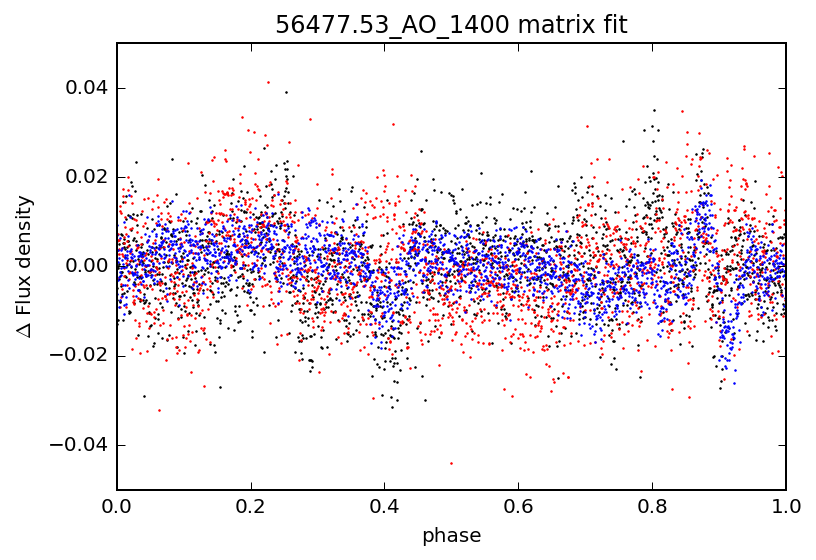

In [13]:
d, x, names = fit_mueller(t_values, r_values)

plt.plot(t_phases,d[0],'.',markersize=markersize,color='k')
plt.plot(t_phases,np.hypot(d[1],d[2]),'.',markersize=markersize,color='r')
plt.plot(t_phases,d[3],'.',markersize=markersize,color='b')
plt.plot(t_phases,t_values[0],color='k',linestyle="-")
plt.plot(t_phases,np.hypot(t_values[1],t_values[2]),color='r',linestyle="-")
plt.plot(t_phases,t_values[3],color='b',linestyle="-")
plt.xlim(0,1)
plt.xlabel("phase")
plt.gca().tick_params("y", left="off", labelleft="off")
plt.title(obsname+" matrix fit")
plt.savefig("polarization-matrix-"+obsname+".pdf")

plt.figure()
plt.plot(t_phases,(t_values-d)[0],'.',markersize=markersize,color='k')
plt.plot(t_phases,np.hypot(t_values[1],t_values[2])-np.hypot(d[1],d[2]),'.',markersize=markersize,color='r')
plt.plot(t_phases,(t_values-d)[3],'.',markersize=markersize,color='b')
plt.xlim(0,1)
plt.xlabel("phase")
plt.ylabel(r"$\Delta$ Flux density")
plt.title(obsname+" matrix fit")
